## Attempt: Constrained Gaussian Process Example

In [10]:
import sys
import time
import random as rnd
import time

import numpy as np 
import matplotlib.pyplot as plt 

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from jax.tree_util import tree_map
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from jax import random
import jax.numpy as jnp
from jax import jit

# PyTorch
import torch
import torch.utils.data as data

# print versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

sys.path.append("..")  # TODO: remove this later, it should be from the installed package.

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.losses import kl_divergence, scaled_sum_squared_loss
from priorCVAE.utility import create_data_loaders
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import CGPDataset

import jax.config as config
config.update("jax_enable_x64", True)

Pytorch version:  2.0.1
Numpyro version:  0.12.1
JAX version:      0.4.13
Flax version:     0.6.11
Optax version:    0.1.5
Pythorch version: 3.10.0


### Set Arguments

In [8]:
args = {"seed": 0,
        
        # data
        "num_data": 4000,
        
        # architecture
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 100,
        "num_epochs": 200,
        "vae_var": 1,     # what is this parameter?

        # MCMC inference
        "true_ls": 0.2,    # is this a parameter for length scale?
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 4,
        "thinning": 1,    # thin=1 is the default value, keeping all values
       }

### Generate Data
Generate from GP, then do linear transformation to achieve constraints.

In [7]:
CGP = jit(CGPDataset)
train_set = CGP(n_data=args["input_dim"], n_samples=args["num_data"])  

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[].
'num' argument of jnp.linspace

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [5]:
train_set.y.max()

Array(4.02336076, dtype=float64)

In [4]:
train_set = GPDataset(n_data=args["input_dim"], n_samples=args["num_data"])  
val_set   = GPDataset(n_data=args["input_dim"], n_samples=args["num_data"])  
test_set  = GPDataset(n_data=args["input_dim"], n_samples=args["num_data"])  

In [27]:
sup = max(jnp.max(train_set.y), jnp.max(val_set.y), jnp.max(test_set.y))
inf = -max(-jnp.min(train_set.y), -jnp.min(val_set.y), -jnp.min(test_set.y))

In [28]:
def lin_op(y):
    return (y-inf)/(sup-inf)

In [55]:
new = jnp.apply_along_axis(lin_op, 0, train_set.y)
train_set.y.at[:,:] = new

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [53]:
train_set.y.max()

Array(4.03777962, dtype=float64)

In [ ]:
val_set.y.at[:,:].set(jnp.apply_along_axis(lin_op, 0, val_set.y))
test_set.y.at[:,:].set(jnp.apply_along_axis(lin_op, 0, test_set.y))

In [33]:
train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=args["batch_size"])
# train the `train_set` but not the other two

# these lines are VERY slow and produce MANY warnings - consider removing them
train_loader_iter = iter(train_loader)
val_loader_iter   = iter(val_loader)
test_loader_iter  = iter(test_loader)

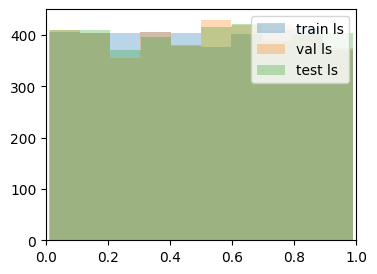

In [34]:
# Check lengthscales
ls_train_set = train_set.ls
ls_val_set   = val_set.ls
ls_test_set  = test_set.ls

plt.figure(figsize=(4,3))
plt.hist(ls_train_set[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set[:, 0],   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()

In [39]:
jnp.max(train_set.y)

Array(4.03777962, dtype=float64)

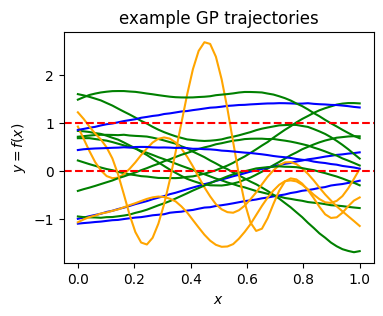

In [36]:
# check: what trajectories are we generating?

# orange for [0,0.2]; green for (0.2,0.6]; blue for (0.6,-)
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')
ax.axhline(0,color = 'r', linestyle = '--')
ax.axhline(1,color = 'r', linestyle = '--')
plt.show()

In [11]:
import time

import matplotlib.pyplot as plt
import jax.config as config
import jax.numpy as jnp

from priorCVAE.datasets import GPDataset
from priorCVAE.priors.kernels import SquaredExponential

config.update("jax_enable_x64", True)

if __name__ == '__main__':

    start_time = time.time()
    gp_dataset_generator = GPDataset(kernel=SquaredExponential(), n_data=400, x_lim_low=0, x_lim_high=1,
                                     sample_lengthscale=True)

    correct_samples = []
    correct_ls = []
    x_val = None  # As it is same for all the data
    while len(correct_samples) <= 10:
        samples_x, samples_y, samples_ls = gp_dataset_generator.simulatedata()
        if x_val is None:
            x_val = samples_x[0]


        def log_constraint_val(x):
            return jnp.log(30 * x + 1)/3 + 0.1

        print("samples_generated!!!")
        total_samples = samples_y.shape[0]

        for s_x, s_y, s_ls in zip(samples_x, samples_y, samples_ls):
            if jnp.min(s_y) >= 0 and jnp.all(log_constraint_val(s_x) - s_y >= 0):
                correct_samples.append(s_y)
                correct_ls.append(s_ls)

    correct_samples = jnp.array(correct_samples).reshape((-1, samples_y.shape[-1]))
    correct_ls = jnp.array(correct_ls).reshape((-1, 1))

    end_time = time.time()
    print(f"Time taken to geneare {correct_samples.shape[0]} samples is {end_time - start_time} secs!")
    for s in correct_samples[: 100]:
        plt.plot(x_val, s,)

    plt.xlim([0, 1])
    plt.ylim([-3, 3])
    plt.show()

    jnp.savez("constrained_gp_samples.npz", x=x_val, y=correct_samples, ls=correct_ls)


TypeError: GPDataset.__init__() got an unexpected keyword argument 'kernel'